In [1]:
import numpy as np

import seaborn as sns
import torch

In [2]:
data = np.load('MLPopulation/data/Combined_GWTC_m1m2chieffz.npz')

m1 = data['m1']

m1 = torch.from_numpy(m1)

def softplus_inv(y):
    return y + y.neg().expm1().neg().log()


logm1 = softplus_inv(m1)
mu = logm1.mean()
std = logm1.std()
logm1 = (logm1 - mu) / std

sns.kdeplot(logm1.mean(-1))

In [8]:
import pyro.distributions as dist
import pyro.distributions.transforms as T

In [9]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

n_samples = 1000
X, y = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
X = StandardScaler().fit_transform(X)


In [10]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.spline_coupling(2, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])



In [11]:
steps = 1
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=5e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))



step: 0, loss: 3.6749930381774902


In [12]:
dataset = torch.tensor(logm1, dtype=torch.float)

/var/folders/d3/x840qlg17x1f92cnsrkq62fw0000gn/T/ipykernel_7891/33368643.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = torch.tensor(logm1, dtype=torch.float)


In [13]:
base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
# spline_transform = T.spline_coupling(1, count_bins=8)
# spline_transform = T.spline(1, count_bins=8)
spline_transform = T.spline_autoregressive(1, count_bins=8)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])




/Users/druhe/Projects/gw/.venv/lib/python3.9/site-packages/pyro/nn/auto_reg_nn.py:179: UserWarning: ConditionalAutoRegressiveNN input_dim = 1. Consider using an affine transformation instead.
  warnings.warn(


In [14]:
import math
import matplotlib.pyplot as plt

step: 0, loss: 1.2875313758850098


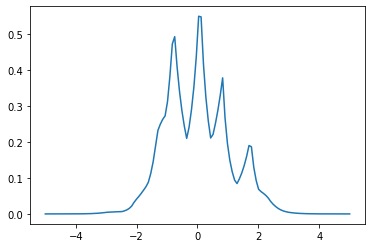

step: 1, loss: 1.278242826461792


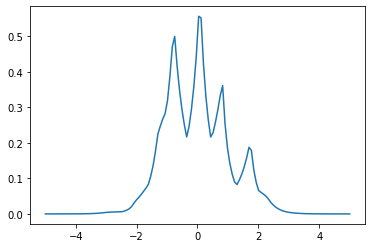

In [15]:
steps = 1
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=5e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    log_prob = flow_dist.log_prob(dataset.view(-1, 1)).view(dataset.shape)
    
    log_prob = torch.logsumexp(log_prob, dim=-1) - math.log(log_prob.shape[-1])
    loss = -log_prob.mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 1 == 0:
        with torch.no_grad():
            print('step: {}, loss: {}'.format(step, loss.item()))
            X = torch.linspace(-5, 5, 128)
            p = flow_dist.log_prob(X[:, None]).exp()
            plt.plot(X.numpy(), p.numpy())
            plt.show()




In [16]:
z = flow_dist.sample((1024,))

In [17]:
z = (z * std) + mu

In [18]:
z = torch.nn.functional.softplus(z)

<AxesSubplot:ylabel='Density'>

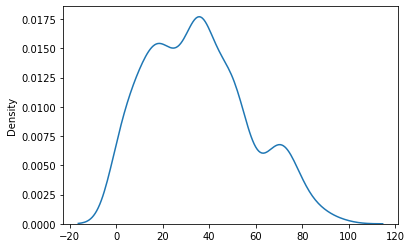

In [19]:
sns.kdeplot(z.squeeze())

In [20]:
data = np.load('MLPopulation/data/Combined_GWTC_m1m2chieffz.npz')

In [21]:
m1 = torch.from_numpy(data['m1'])
m2 = torch.from_numpy(data['m2'])

# randindex = torch.randint(0, 30000, (30000,))
# m1 = m1[:, randindex]
# m2 = m2[:, randindex]

dim = 2
X = torch.stack([m1, m2], dim=-1)

In [22]:
X = softplus_inv(X)
# X = X.log()

In [23]:
mu = torch.mean(X.view(-1, dim), dim=0, keepdim=True)
std = torch.std(X.view(-1, dim), dim=0, keepdim=True)

In [24]:
X = (X - mu) / std
dataset = X.float()

In [25]:
X_val = X[-10:].float()
X = X[:-10].float()

In [26]:
base_dist = dist.Normal(torch.zeros(dim), torch.ones(dim))
spline_transform_1 = T.spline_autoregressive(dim, count_bins=8)
# spline_transform_2 = T.spline_autoregressive(dim, count_bins=8)
spline_transform_2 = T.affine_autoregressive(dim)
spline_transform = T.ComposeTransformModule([spline_transform_1, spline_transform_2])
flow_dist = dist.TransformedDistribution(base_dist, spline_transform)





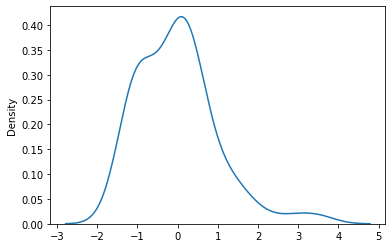

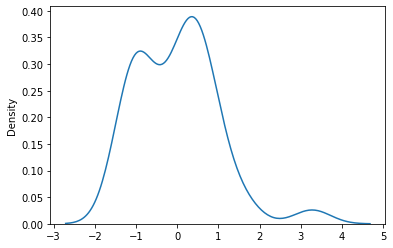

In [27]:
for i in range(X.shape[-1]):
    sns.kdeplot(X[:, :, i].mean(-1))
    plt.show()

In [28]:
# steps = 5000
# optimizer = torch.optim.Adam(spline_transform.parameters(), lr=5e-3)
# for step in range(steps+1):
#     optimizer.zero_grad()
#     log_prob = flow_dist.log_prob(dataset.view(-1, dim)).view(dataset.shape[:-1])
    
#     log_prob = torch.logsumexp(log_prob, dim=-1) - math.log(log_prob.shape[-1])
#     loss = -log_prob.mean()
#     loss.backward()
#     optimizer.step()
#     flow_dist.clear_cache()

#     if step % 1 == 0:
#         print('step: {}, loss: {}'.format(step, loss.item()))


#         with torch.no_grad():
#             if dim == 1:
#                 X = torch.linspace(-5, 5, 128)
#                 p = flow_dist.log_prob(X[:, None]).exp()
#                 plt.plot(X.numpy(), p.numpy())
#                 plt.show()
#             else:
#                 linspace = torch.linspace(-5, 5, 128)
#                 grid = torch.meshgrid(linspace, linspace, indexing='xy')
#                 grid = torch.stack(grid).view(2, -1).permute(1, 0)
#                 p = flow_dist.log_prob(grid).exp().view(128, 128)
#                 plt.plot(linspace.numpy(), p.sum(0).numpy())
#                 plt.show()
                
#                 plt.plot(linspace.numpy(), p.sum(1).numpy())
#                 plt.show()
                







In [30]:
base_dist = dist.Normal(torch.zeros(dim), torch.ones(dim))
spline_transform_1 = T.spline_autoregressive(dim, count_bins=8)

spline_transform_2 = T.spline_autoregressive(dim, count_bins=8)
# spline_transform_2 = T.affine_autoregressive(dim)
spline_transform = T.ComposeTransformModule([spline_transform_1])

spline_transform = T.ComposeTransformModule([T.spline_autoregressive(dim) for _ in range(4)])
flow_dist = dist.TransformedDistribution(base_dist, spline_transform)






step: 0, loss: 2.978358507156372


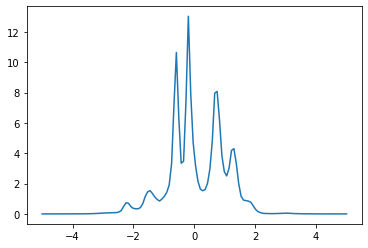

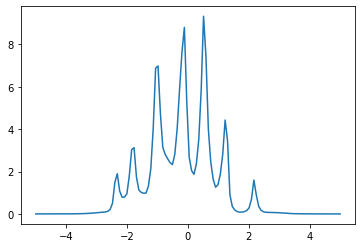

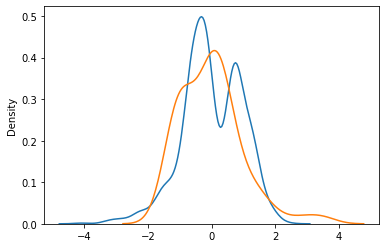

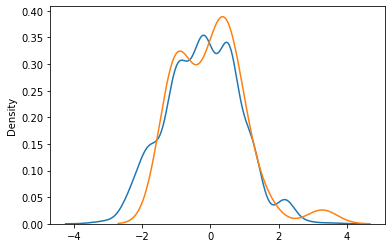

val loss 2.978358507156372
step: 1, loss: 2.8013699054718018


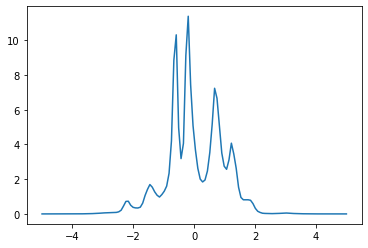

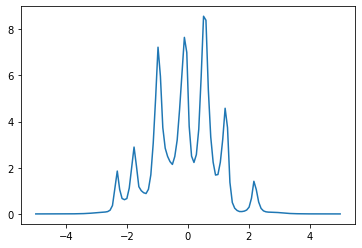

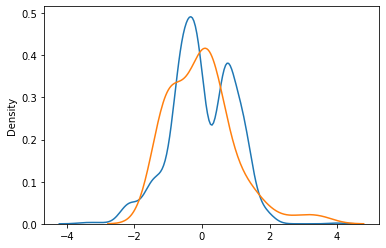

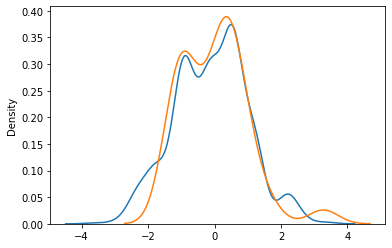

val loss 2.8013699054718018
step: 2, loss: 2.65175461769104


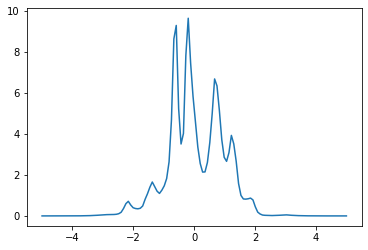

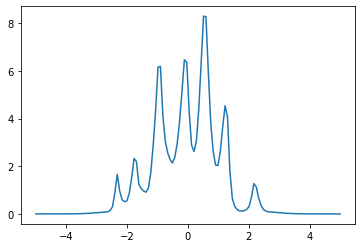

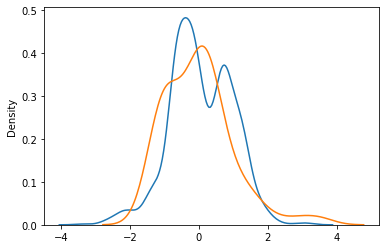

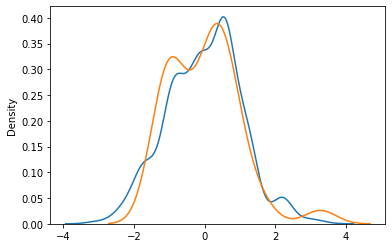

val loss 2.65175461769104
step: 3, loss: 2.4748332500457764


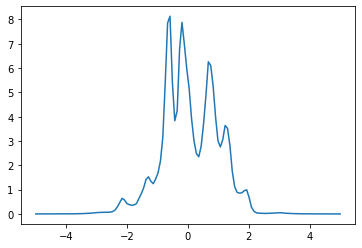

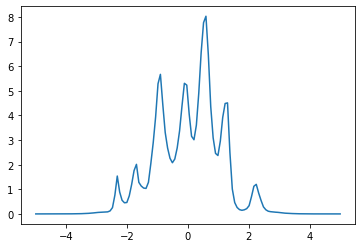

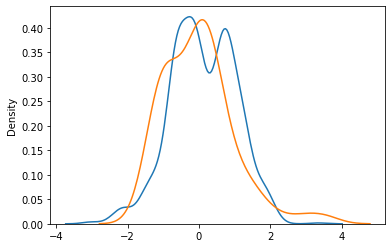

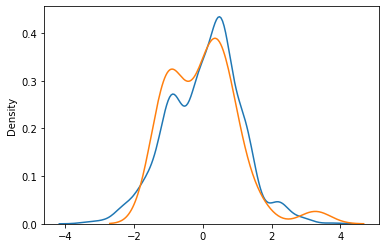

val loss 2.4748332500457764
step: 4, loss: 2.334986925125122


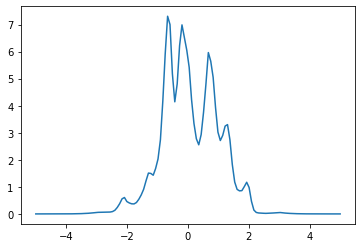

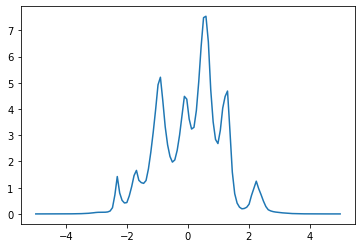

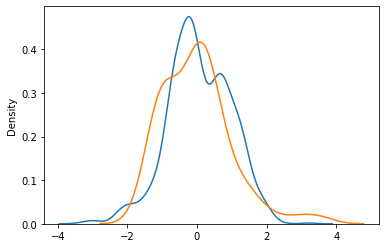

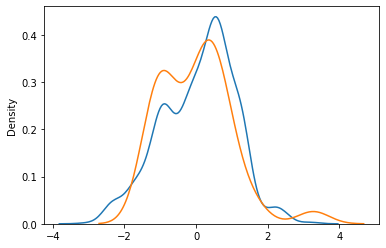

val loss 2.334986925125122
step: 5, loss: 2.1735661029815674


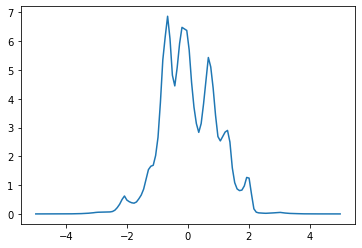

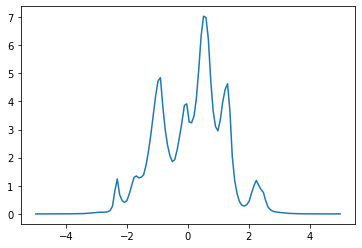

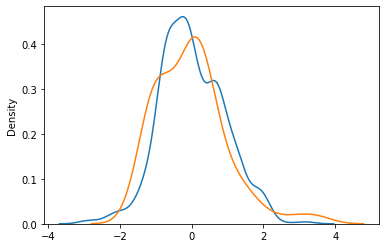

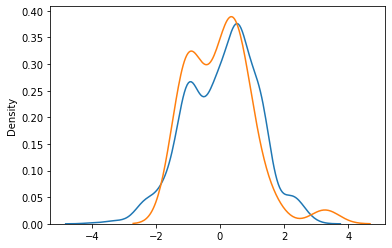

val loss 2.1735661029815674
step: 6, loss: 2.0239152908325195


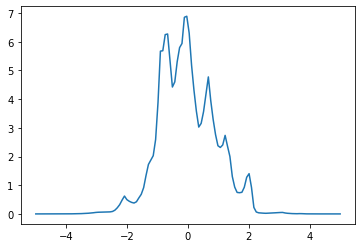

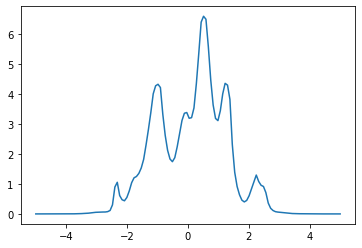

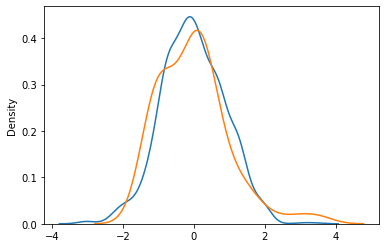

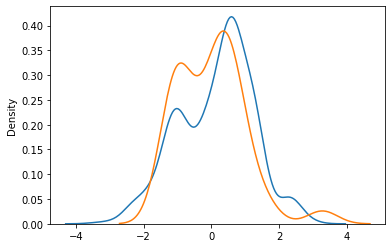

val loss 2.0239152908325195
step: 7, loss: 1.908263087272644


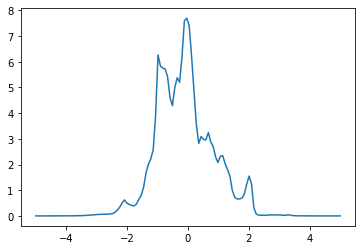

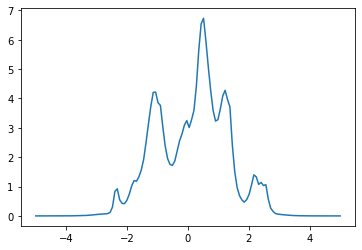

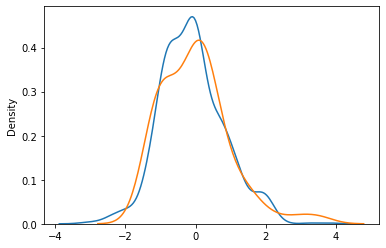

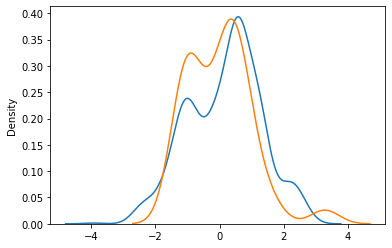

val loss 1.908263087272644
step: 8, loss: 1.8119380474090576


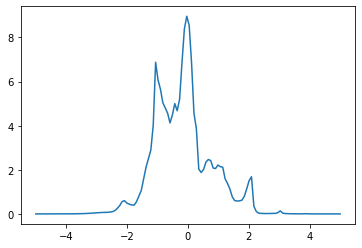

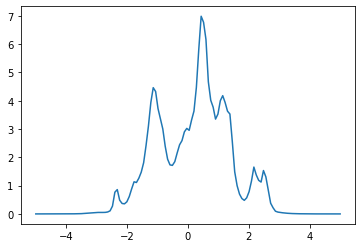

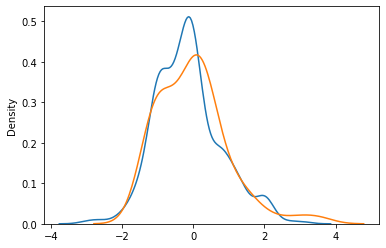

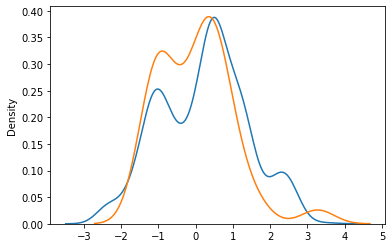

val loss 1.8119380474090576
step: 9, loss: 1.7053321599960327


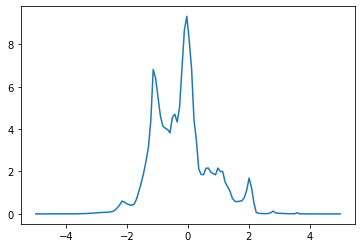

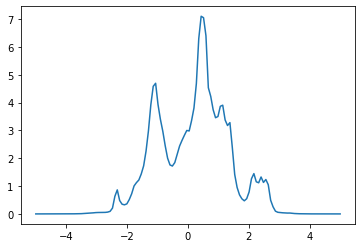

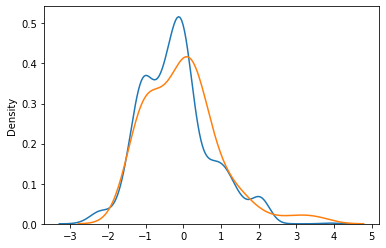

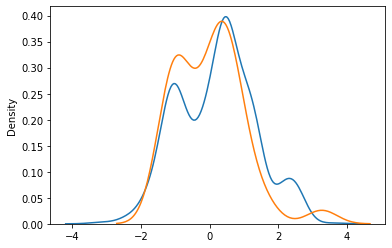

val loss 1.7053321599960327
step: 10, loss: 1.6617071628570557


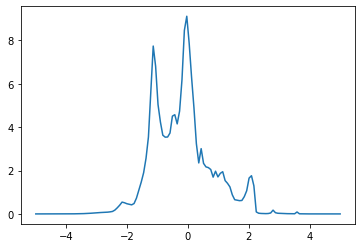

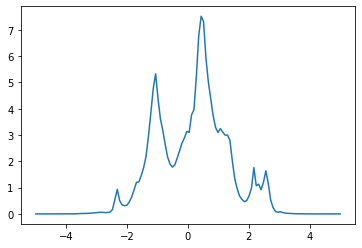

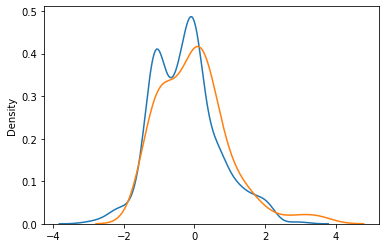

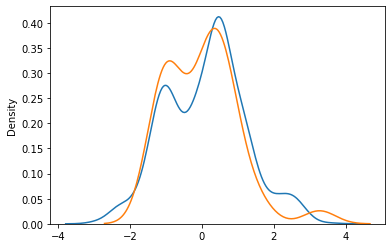

val loss 1.6617071628570557
step: 11, loss: 1.5822391510009766


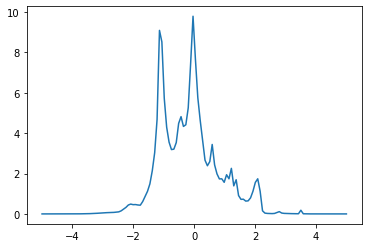

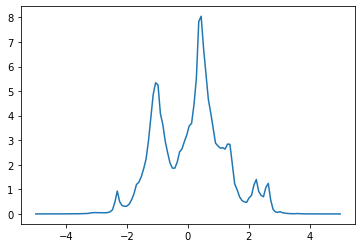

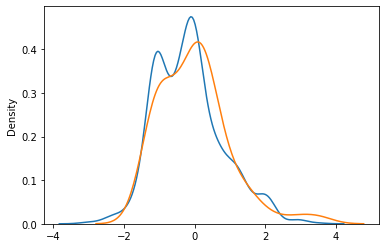

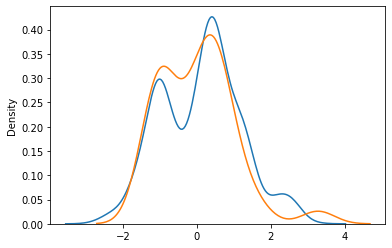

val loss 1.5822391510009766
step: 12, loss: 1.512656569480896


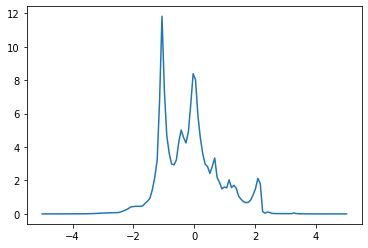

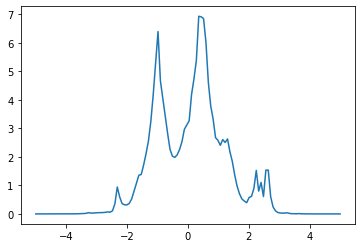

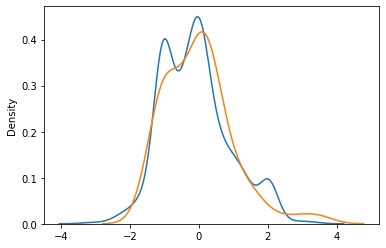

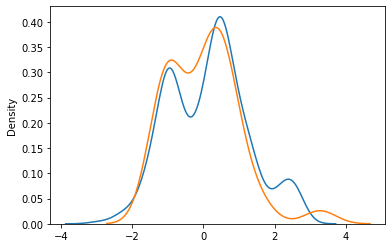

val loss 1.512656569480896
step: 13, loss: 1.4718765020370483


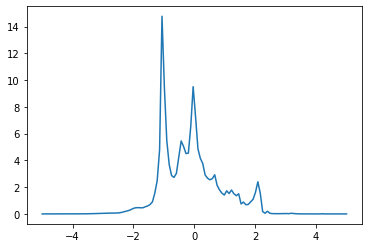

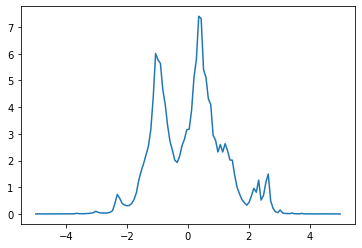

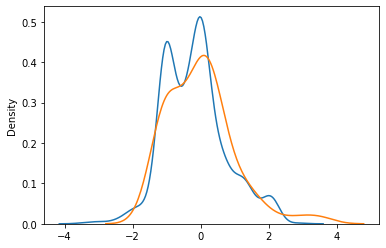

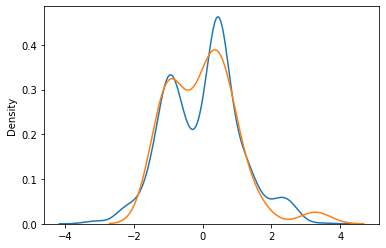

val loss 1.4718765020370483
step: 14, loss: 1.457362174987793


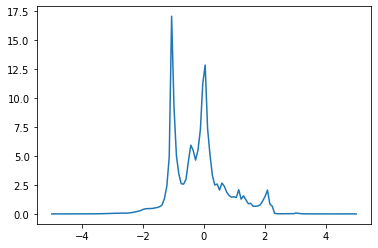

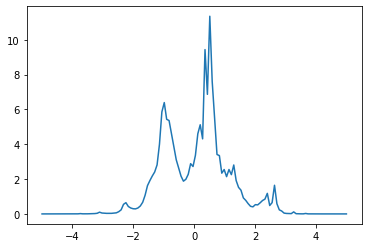

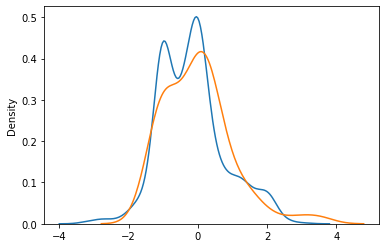

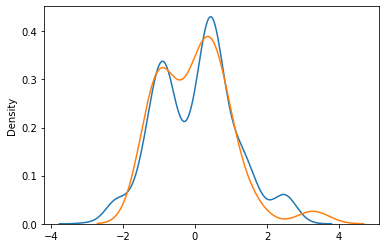

val loss 1.457362174987793
step: 15, loss: 1.4381569623947144


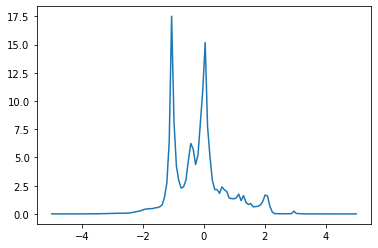

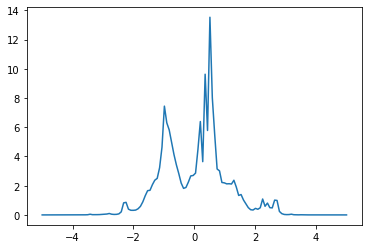

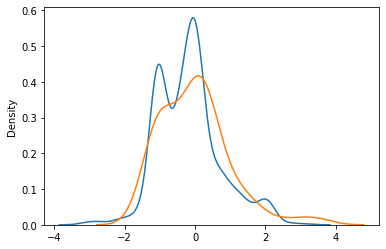

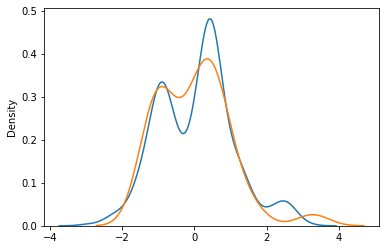

val loss 1.4381569623947144
step: 16, loss: 1.396248459815979


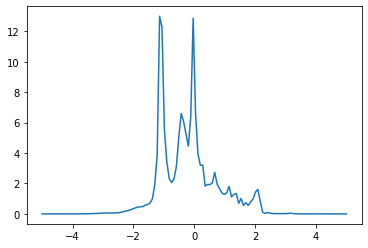

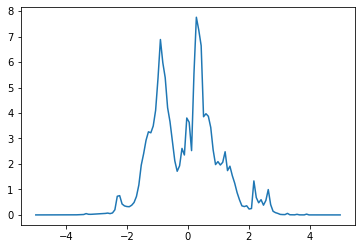

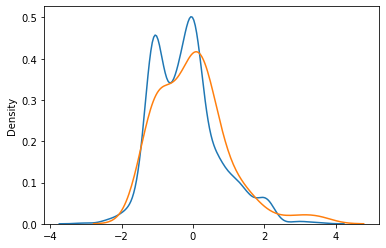

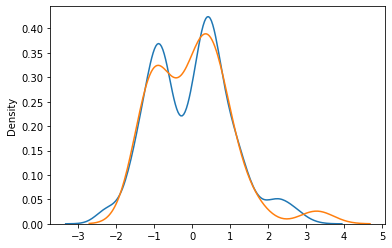

In [31]:
steps = 5000

best_val_loss = float('inf')
batch_size=1024
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=5e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    randindex = torch.randint(0, 30000, (batch_size,))
    batch = X[:, randindex, :]

    log_prob = flow_dist.log_prob(batch.view(-1, dim)).view(batch.shape[:-1])
    
    log_prob = torch.logsumexp(log_prob, dim=-1) - math.log(log_prob.shape[-1])
    loss = -log_prob.mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()
    if step % 1 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))


        with torch.no_grad():
            if dim == 1:
                X = torch.linspace(-5, 5, 128)
                p = flow_dist.log_prob(X[:, None]).exp()
                plt.plot(X.numpy(), p.numpy())
                plt.show()
            else:
                linspace = torch.linspace(-5, 5, 128)
                grid = torch.meshgrid(linspace, linspace, indexing='xy')
                grid = torch.stack(grid).view(2, -1).permute(1, 0)
                p = flow_dist.log_prob(grid).exp().view(128, 128)
                plt.plot(linspace.numpy(), p.sum(0).numpy())
                plt.show()
                
                plt.plot(linspace.numpy(), p.sum(1).numpy())
                plt.show()
                
                samples = flow_dist.sample((1024,))
                sns.kdeplot(samples[:, 0].numpy())
                sns.kdeplot(X[:, :, 0].mean(1).numpy())
                plt.show()
                
                sns.kdeplot(samples[:, 1].numpy())
                sns.kdeplot(X[:, :, 1].mean(1).numpy())
                plt.show()


            log_prob_val = flow_dist.log_prob(X_val.view(-1, dim)).view(X_val.shape[:-1])

            log_prob_val = torch.logsumexp(log_prob_val, dim=-1) - math.log(log_prob_val.shape[-1])
            val_loss = -log_prob_val.mean()
            if val_loss > best_val_loss:
                break
            else:
                best_val_loss = val_loss
            print("val loss", loss.item())








In [32]:
import torch.nn.functional as F

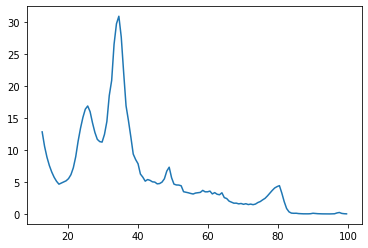

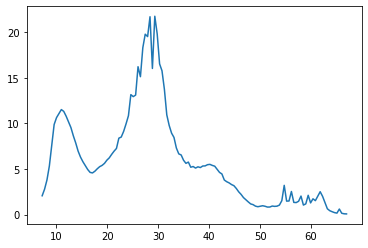

In [33]:
with torch.no_grad():   
        linspace = torch.linspace(-1, 3, 128)
        grid = torch.meshgrid(linspace, linspace, indexing='xy')
        grid = torch.stack(grid).view(2, -1).permute(1, 0)
        p = flow_dist.log_prob(grid).exp().view(128, 128)
        linspace_normalized = F.softplus(linspace[:, None] * std + mu).squeeze()
        plt.plot(linspace_normalized[:, 0], p.sum(0).numpy())
        plt.show()

        plt.plot(linspace_normalized[:, 1].numpy().squeeze(), p.sum(1).numpy())
        plt.show()

#         samples = flow_dist.sample((1024,))
#         sns.kdeplot(samples[:, 0].numpy())
#         sns.kdeplot(X[:, :, 0].mean(1).numpy())
#         plt.show()

#         sns.kdeplot(samples[:, 1].numpy())
#         sns.kdeplot(X[:, :, 1].mean(1).numpy())
#         plt.show()



In [34]:
linspace_normalized * std

tensor([[ 276.1508,  107.5231],
        [ 290.9751,  114.5600],
        [ 305.7994,  121.5984],
        [ 320.6238,  128.6379],
        [ 335.4482,  135.6780],
        [ 350.2725,  142.7185],
        [ 365.0969,  149.7592],
        [ 379.9212,  156.8001],
        [ 394.7456,  163.8410],
        [ 409.5700,  170.8821],
        [ 424.3943,  177.9231],
        [ 439.2187,  184.9642],
        [ 454.0430,  192.0053],
        [ 468.8674,  199.0464],
        [ 483.6918,  206.0875],
        [ 498.5161,  213.1286],
        [ 513.3405,  220.1698],
        [ 528.1648,  227.2109],
        [ 542.9892,  234.2520],
        [ 557.8136,  241.2931],
        [ 572.6379,  248.3342],
        [ 587.4623,  255.3754],
        [ 602.2866,  262.4165],
        [ 617.1110,  269.4576],
        [ 631.9354,  276.4987],
        [ 646.7597,  283.5398],
        [ 661.5841,  290.5810],
        [ 676.4084,  297.6221],
        [ 691.2328,  304.6632],
        [ 706.0572,  311.7043],
        [ 720.8815,  318.7454],
        